## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random

In [2]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet

## PARAMETERS

In [3]:
VALID_SIZE = 0.3
TEST_SIZE  = 0.1
BATCH_SIZE = 4
EPOCHS = 20
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## DIRECTORIES

In [4]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [5]:
ROOT_DIR='C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\'

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks')

In [8]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"images\\"+image_paths[i]

In [9]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [10]:
image_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internsh

In [11]:
mask_paths

['cfcu_002387.png',
 'cfcu_002403.png',
 'cfcu_002411.png',
 'cfcu_002419.png',
 'cfcu_002427.png',
 'cfcu_002435.png',
 'cfcu_002443.png',
 'cfcu_002451.png',
 'cfcu_002459.png',
 'cfcu_002467.png',
 'cfcu_002475.png',
 'cfcu_002483.png',
 'cfcu_002491.png',
 'cfcu_002499.png']

In [12]:
line_mask_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHu

## Json2Mask

In [13]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [14]:
mask=plt.imread(mask_paths[0])

In [15]:
mask_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Proje

In [21]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

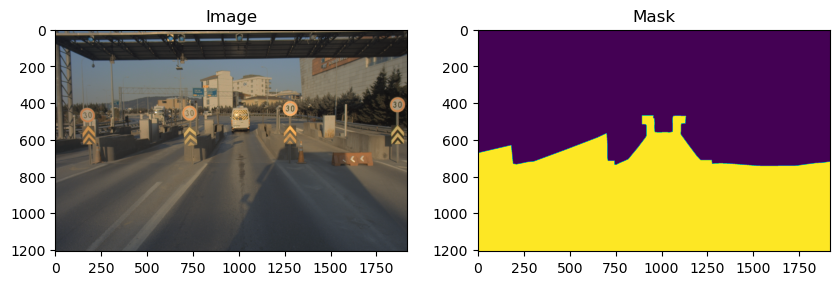

In [22]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [23]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

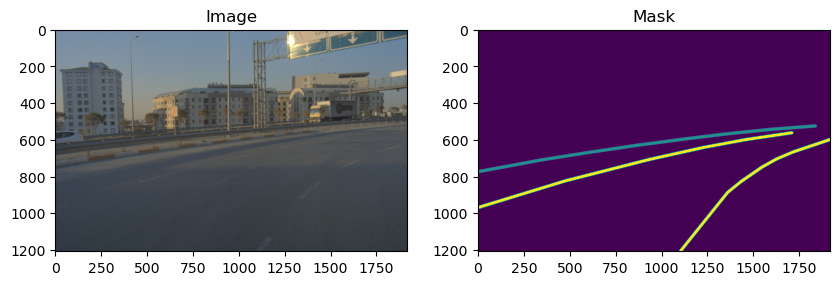

In [24]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [25]:
image=plt.imread(image_paths[4])
mask=plt.imread(mask_paths[4])

In [26]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [27]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569


In [28]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [29]:
image=plt.imread(image_paths[0])

In [30]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [31]:
torch_like_data_example=preprocess.torchlike_data(image)

In [32]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [33]:
example_mask=plt.imread(mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=2)

In [34]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 2)


## tensorize_image method

In [35]:
tensorized_images=preprocess.tensorize_image(image_paths,(224,224))

In [36]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [39]:
tensorized_images[0]

tensor([[[ 68.,  67.,  67.,  ..., 154., 154., 155.],
         [ 68.,  68.,  71.,  ..., 155., 157., 156.],
         [ 68.,  70.,  68.,  ..., 154., 159., 155.],
         ...,
         [ 64.,  64.,  60.,  ...,  66.,  55.,  55.],
         [ 64.,  63.,  64.,  ...,  54.,  61.,  57.],
         [ 65.,  66.,  64.,  ...,  61.,  61.,  56.]],

        [[ 62.,  61.,  62.,  ..., 144., 141., 142.],
         [ 62.,  62.,  62.,  ..., 143., 144., 142.],
         [ 63.,  62.,  63.,  ..., 141., 143., 141.],
         ...,
         [ 53.,  56.,  51.,  ...,  53.,  49.,  51.],
         [ 53.,  56.,  56.,  ...,  49.,  53.,  50.],
         [ 54.,  55.,  58.,  ...,  54.,  52.,  49.]],

        [[ 56.,  56.,  57.,  ..., 126., 126., 127.],
         [ 59.,  57.,  60.,  ..., 128., 126., 127.],
         [ 56.,  57.,  58.,  ..., 129., 129., 126.],
         ...,
         [ 46.,  50.,  45.,  ...,  48.,  44.,  46.],
         [ 48.,  50.,  48.,  ...,  44.,  46.,  44.],
         [ 48.,  47.,  50.,  ...,  46.,  46.,  42.]]]

## tensorize_mask.() method

In [40]:
tensorized_masks=preprocess.tensorize_mask(mask_paths,(constant.HEIGHT,constant.WIDTH),n_class=2)

In [41]:
tensorized_masks.shape

torch.Size([14, 2, 224, 224])

In [42]:
tensorized_masks[3]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model

In [43]:
model=Unet(in_channels=3,out_channels=2)

In [44]:
outputs=model.forward(tensorized_images)

In [45]:
outputs[0].shape

torch.Size([2, 224, 224])

In [46]:
tensorized_images.shape

torch.Size([14, 3, 224, 224])

In [47]:
outputs[5]

tensor([[[-0.3233,  0.9714, -0.0926,  ...,  0.7688,  0.5728,  0.5839],
         [-0.5087,  0.0709, -0.0097,  ...,  0.9076,  0.6234,  0.4251],
         [-0.1676, -0.3040, -0.4382,  ..., -0.4125, -0.8240, -0.2079],
         ...,
         [ 0.0288,  0.1296, -0.4008,  ..., -0.2802, -0.2265,  0.1442],
         [ 0.0552, -0.0332, -0.2425,  ..., -0.1345, -0.2593,  0.2675],
         [ 0.6022,  0.4957,  0.1667,  ...,  0.4741,  0.6869,  0.3661]],

        [[ 0.2116, -0.6309, -0.0944,  ..., -0.7933, -0.5230, -0.5324],
         [-0.5177, -2.0161, -1.5706,  ..., -1.3647, -1.0500, -0.9193],
         [-0.9277, -1.3390, -1.1133,  ..., -0.3943, -0.7484,  0.0862],
         ...,
         [-0.2051, -0.1544, -0.1254,  ...,  0.0404, -0.2561,  0.1353],
         [-0.3648, -0.2348, -0.4112,  ..., -0.1858, -0.6691,  0.1111],
         [-0.3945, -0.3231, -0.5900,  ..., -0.4419, -0.3167, -0.1126]]],
       grad_fn=<SelectBackward0>)

In [48]:
outputs[5].shape

torch.Size([2, 224, 224])